In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import joblib
import seaborn as sns

In [63]:
#Loading the dataset
df = pd.read_csv("earthquake_1995-2023.csv")
print(df.head())

                                      title  magnitude         date_time  cdi  \
0          M 6.5 - 42 km W of Sola, Vanuatu        6.5  16-08-2023 12:47    7   
1  M 6.5 - 43 km S of Intipucá, El Salvador        6.5  19-07-2023 00:22    8   
2  M 6.6 - 25 km ESE of Loncopué, Argentina        6.6  17-07-2023 03:05    7   
3     M 7.2 - 98 km S of Sand Point, Alaska        7.2  16-07-2023 06:48    6   
4                  M 7.3 - Alaska Peninsula        7.3  16-07-2023 06:48    0   

   mmi   alert  tsunami  sig net  nst      dmin    gap magType    depth  \
0    4   green        0  657  us  114  7.177000   25.0     mww  192.955   
1    6  yellow        0  775  us   92  0.679000   40.0     mww   69.727   
2    5   green        0  899  us   70  1.634000   28.0     mww  171.371   
3    6   green        1  860  us  173  0.907000   36.0     mww   32.571   
4    5     NaN        1  820  at   79  0.879451  172.8      Mi   21.000   

   latitude  longitude               location      continent  

In [3]:
#Basic Info
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1000 non-null   object 
 1   magnitude  1000 non-null   float64
 2   date_time  1000 non-null   object 
 3   cdi        1000 non-null   int64  
 4   mmi        1000 non-null   int64  
 5   alert      449 non-null    object 
 6   tsunami    1000 non-null   int64  
 7   sig        1000 non-null   int64  
 8   net        1000 non-null   object 
 9   nst        1000 non-null   int64  
 10  dmin       1000 non-null   float64
 11  gap        1000 non-null   float64
 12  magType    1000 non-null   object 
 13  depth      1000 non-null   float64
 14  latitude   1000 non-null   float64
 15  longitude  1000 non-null   float64
 16  location   994 non-null    object 
 17  continent  284 non-null    object 
 18  country    651 non-null    object 
dtypes: float64(6), int64(5), object(8)
memory usage: 


Dataset shape: (1000, 19)

Columns: ['title', 'magnitude', 'date_time', 'cdi', 'mmi', 'alert', 'tsunami', 'sig', 'net', 'nst', 'dmin', 'gap', 'magType', 'depth', 'latitude', 'longitude', 'location', 'continent', 'country']

Missing Values (%):
 title         0.0
magnitude     0.0
date_time     0.0
cdi           0.0
mmi           0.0
alert        55.1
tsunami       0.0
sig           0.0
net           0.0
nst           0.0
dmin          0.0
gap           0.0
magType       0.0
depth         0.0
latitude      0.0
longitude     0.0
location      0.6
continent    71.6
country      34.9
dtype: float64


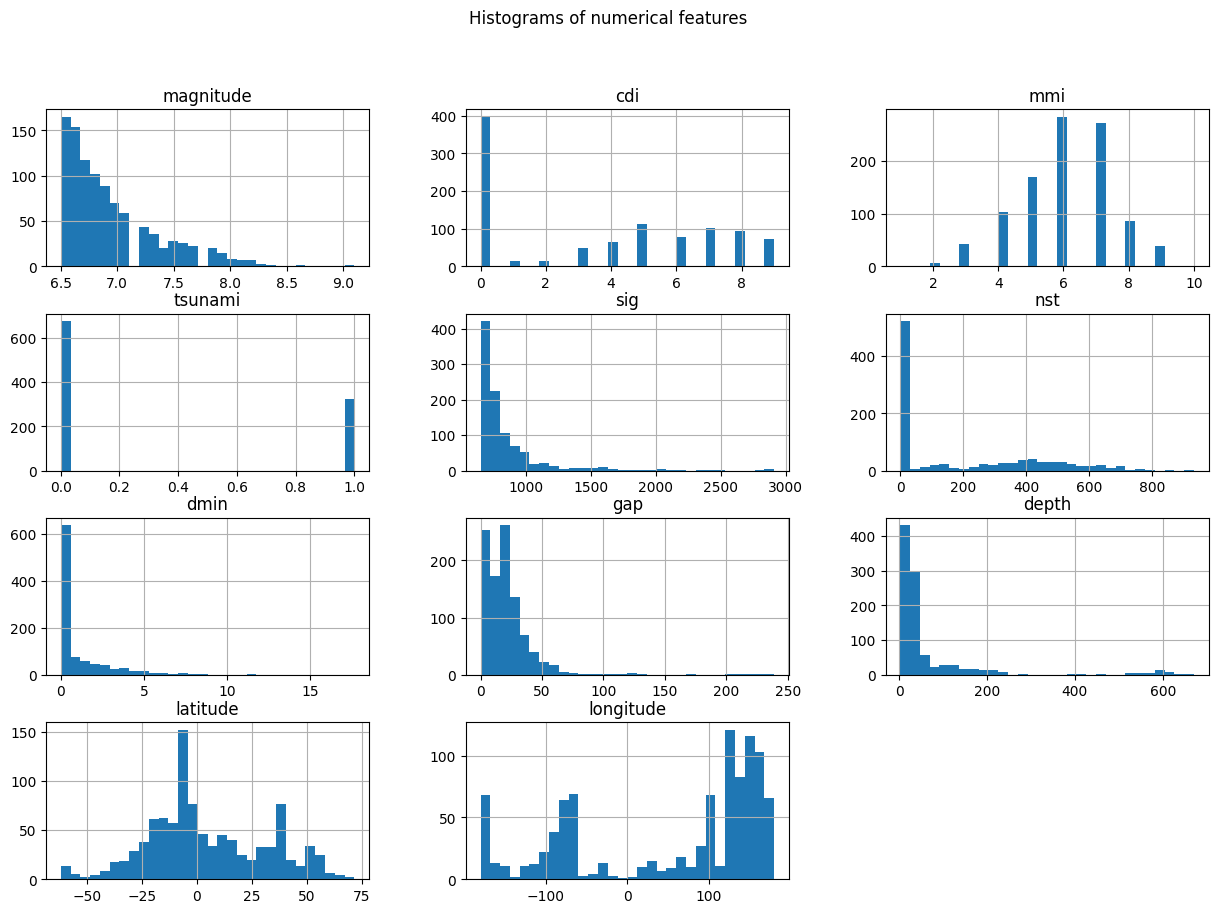

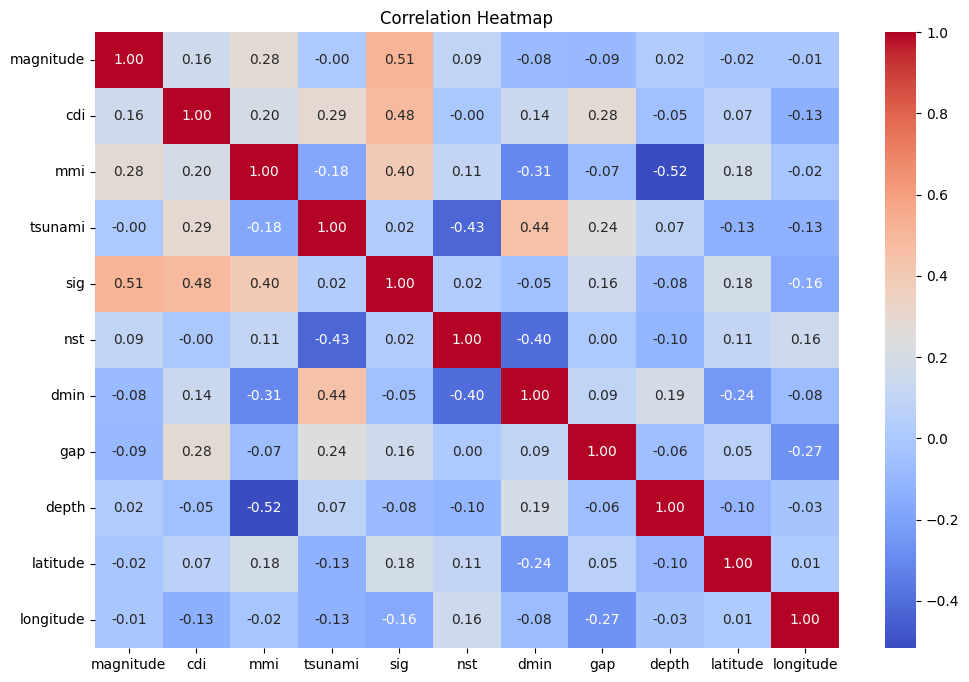

In [4]:
# 2. EDA
print("\nDataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
# Missing value %
missing_percent = (df.isnull().sum() / len(df)) * 100
print("\nMissing Values (%):\n", missing_percent)
# Distribution of numerical features
df.hist(bins=30, figsize=(15,10))
plt.suptitle("Histograms of numerical features")
plt.show()
# Correlation heatmap
plt.figure(figsize=(12,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [64]:
# 3. Data Transformation
# Create Severity label from Magnitude
df["Severity"] = pd.qcut(df["magnitude"], q=3, labels=["Low", "Moderate", "Severe"])
# Define Features (X) and Target (y)
X = df.drop(columns=["Severity", "Date", "Time", "Location"], errors="ignore")
y = df["Severity"]
# Handle missing values
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        X[col] = X[col].fillna(X[col].median())
    else:
        X[col] = X[col].fillna(X[col].mode()[0])
# Encode categorical columns
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col])
# Scale numerical columns
scaler = StandardScaler()
num_cols = X.select_dtypes(include=[np.number]).columns
X[num_cols] = scaler.fit_transform(X[num_cols])
print("\n=== Transformed Data ===")
print(X.head())


=== Transformed Data ===
      title  magnitude  date_time       cdi       mmi     alert   tsunami  \
0 -1.429956  -1.005072   0.151111  1.020345 -1.414246 -0.304576 -0.693889   
1 -1.426426  -1.005072   0.491174  1.320888 -0.018838  3.720653 -0.693889   
2 -0.932294  -0.776724   0.263297  1.020345 -0.716542 -0.304576 -0.693889   
3  1.012470   0.593361   0.119559  0.719801 -0.018838 -0.304576  1.441153   
4  1.136004   0.821709   0.119559 -1.083459 -0.716542 -0.304576  1.441153   

        sig       net       nst      dmin       gap   magType     depth  \
0 -0.632899  0.177319 -0.334488  2.920586  0.166930  0.702122  0.905124   
1 -0.241719  0.177319 -0.426567 -0.215322  0.781591  0.702122 -0.037366   
2  0.169351  0.177319 -0.518645  0.245557  0.289862  0.702122  0.740042   
3  0.040063  0.177319 -0.087550 -0.105290  0.617682  0.702122 -0.321548   
4 -0.092541 -6.155506 -0.480977 -0.118585  6.223393 -6.480712 -0.410047   

   latitude  longitude  location  continent   country  
0 -0

In [65]:
# Drop rows with missing target
df = df.dropna(subset=["Severity"])
# Features and Target
X = df.drop(columns=["Severity", "Magnitude", "Date", "Time", "Location"], errors="ignore")
y = df["Severity"]
# Handle missing values in X
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        X[col] = X[col].fillna(X[col].median())
    else:
        X[col] = X[col].fillna(X[col].mode()[0])
# Encode categorical variables
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col])
# Scale numerical variables
scaler = StandardScaler()
num_cols = X.select_dtypes(include=[np.number]).columns
X[num_cols] = scaler.fit_transform(X[num_cols])
# Feature Selection with RandomForest
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X, y)
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("\n=== Feature Importances ===")
print(importances)


=== Feature Importances ===
      Feature  Importance
1   magnitude    0.396643
0       title    0.362674
7         sig    0.178515
3         cdi    0.009597
4         mmi    0.008266
11        gap    0.006926
13      depth    0.006106
15  longitude    0.004396
14   latitude    0.004269
2   date_time    0.003916
16   location    0.003858
10       dmin    0.003035
9         nst    0.002882
18    country    0.002637
12    magType    0.001557
5       alert    0.001472
17  continent    0.001258
6     tsunami    0.001183
8         net    0.000810


In [66]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (800, 19)
Test set shape: (200, 19)


In [67]:
# 5. Model Training
model = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [68]:
# Logistic Regression (for comparison)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [69]:
# 6. Evaluation
# Predictions
rf_preds = rf_model.predict(X_test)
lr_preds = lr_model.predict(X_test)

In [70]:
# Accuracy
print("\n=== Model Accuracy ===")
print("Random Forest:", accuracy_score(y_test, rf_preds))
print("Logistic Regression:", accuracy_score(y_test, lr_preds))


=== Model Accuracy ===
Random Forest: 0.49
Logistic Regression: 0.99


In [71]:
# Classification Report
print("\n=== Random Forest Report ===")
print(classification_report(y_test, rf_preds))
print("\n=== Logistic Regression Report ===")
print(classification_report(y_test, lr_preds))


=== Random Forest Report ===
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00        87
    Moderate       0.30      0.71      0.42        52
      Severe       0.80      1.00      0.89        61

    accuracy                           0.49       200
   macro avg       0.37      0.57      0.44       200
weighted avg       0.32      0.49      0.38       200


=== Logistic Regression Report ===
              precision    recall  f1-score   support

         Low       1.00      0.99      0.99        87
    Moderate       0.98      0.98      0.98        52
      Severe       0.98      1.00      0.99        61

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



C:\Users\Tulasi Sreemoukthika\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Tulasi Sreemoukthika\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Tulasi Sreemoukthika\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

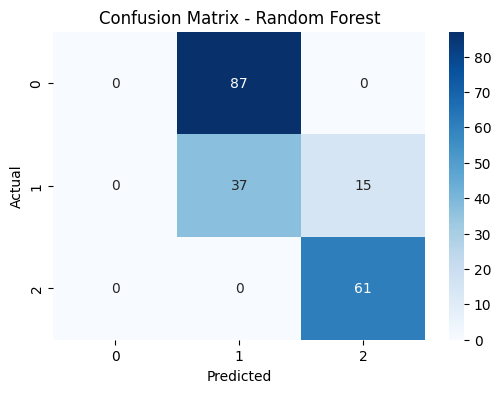

In [72]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [73]:
# 7. Cross-Validation
cv_scores = cross_val_score(rf_model, X, y, cv=5)
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0


In [74]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

print("\n=== Best Parameters from GridSearch ===")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits

=== Best Parameters from GridSearch ===
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [42]:
# 9. Final Evaluation
final_preds = best_model.predict(X_test)

print("\nFinal Model Accuracy:", accuracy_score(y_test, final_preds))
print("\nFinal Classification Report:")
print(classification_report(y_test, final_preds))


Final Model Accuracy: 1.0

Final Classification Report:
              precision    recall  f1-score   support

    Moderate       1.00      1.00      1.00       125
      Severe       1.00      1.00      1.00        75

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [75]:
# 10. Save Model
joblib.dump(best_model, "earthquake_severity_model.pkl")
joblib.dump(X.columns.tolist(), "feature_columns.pkl")
print("\nModels saved are 'earthquake_severity_model.pkl' and feature_columns.pkl")


Models saved are 'earthquake_severity_model.pkl' and feature_columns.pkl


Predicted Severity: Severe
Prediction Probabilities: {'Low': 0.02, 'Moderate': 0.47, 'Severe': 0.51}


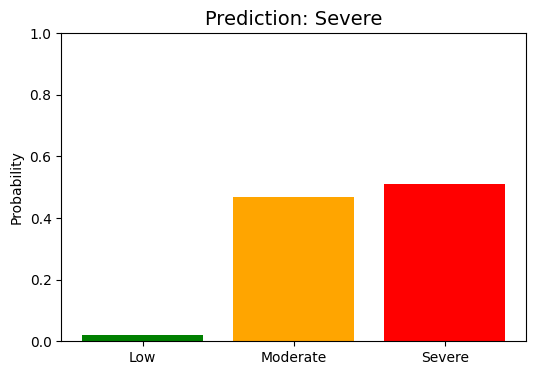

In [80]:
# Load model and feature list
import joblib, pandas as pd, matplotlib.pyplot as plt

model = joblib.load("earthquake_severity_model.pkl")
feature_columns = joblib.load("feature_columns.pkl")

# Example new earthquake record
new_data = pd.DataFrame([{
    "magnitude" : 7,
    "depth": 12,
    "latitude": 34.05,
    "longitude": -118.25,
    "location": "California"
}])

# Fill missing
new_data = new_data.fillna(0)

# Convert categoricals → dummies
new_data = pd.get_dummies(new_data, drop_first=True)

# Align with training columns
new_data = new_data.reindex(columns=feature_columns, fill_value=0)

# Predict label
prediction = model.predict(new_data)[0]

# Predict probabilities
probs = model.predict_proba(new_data)[0]

# Get class labels in same order as probs
classes = model.classes_

print("Predicted Severity:", prediction)
print("Prediction Probabilities:", dict(zip(classes, probs)))

# --- Visualization for Interface ---
colors = {"Low": "green", "Moderate": "orange", "Severe": "red"}

plt.figure(figsize=(6,4))
plt.bar(classes, probs, color=[colors[c] for c in classes])
plt.title(f"Prediction: {prediction}", fontsize=14)
plt.ylabel("Probability")
plt.ylim(0,1)
plt.show()
